In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os

# Dynamically add project root to sys.path
PROJECT_ROOT = os.path.abspath("..")  # Adjust if necessary
if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)

# Verify sys.path
print("Project root added to sys.path:", PROJECT_ROOT)

from utils.config import *

from src.adjustcls import *
from src.adjustl1 import *
from src.decomposer import *
from utils.loadsimulation import *
from utils.moments import *
from utils.image import *

plt.rcParams.update({
    'axes.titlesize': 22,            # Font size for the plot titles
    'axes.labelsize': 20,            # Font size for the x and y labels
    'legend.fontsize': 16,           # Font size for the legend
    'xtick.labelsize': 20,           # Font size for the x-tick labels
    'ytick.labelsize': 20,           # Font size for the y-tick labels
    'axes.linewidth': 3.5,           # Width of the axes' lines
    'xtick.major.width': 3.25,       # Width of the major x-tick lines
    'ytick.major.width': 3.25,       # Width of the major y-tick lines
    'xtick.minor.width': 4.0,        # Width of the minor x-tick lines
    'ytick.minor.width': 4.0,        # Width of the minor y-tick lines
    'figure.titlesize': 20,          # Font size for figure titles
    'legend.handlelength': 2,        # Length of the legend lines
    'legend.handleheight': 0.7,      # Height of the legend markers
    'legend.labelspacing': 0.5,      # Vertical spacing between legend entries
    'lines.linewidth': 3.0,          # Line width for plot lines
    'lines.markersize': 3,           # Size of markers in plot lines
    'axes.grid': False,               # Enable grid on all plots
    'grid.alpha': 0.75,              # Set gridline transparency
    'grid.linestyle': '--',          # Set gridline style
    'grid.linewidth': 0.7,           # Set gridline width
    'grid.color': 'gray',            # Set gridline color
})

Project root added to sys.path: /feynman/work/dap/lcs/vt272285/Generative modelling of convergence map
Global imports loaded successfully!


The number of scales is:  5
the target pixelsize is:  0.3097573567372225
the target size is:  (1024, 1024)
The number of scales is:  5
 Iteration: 149 Scale: 5

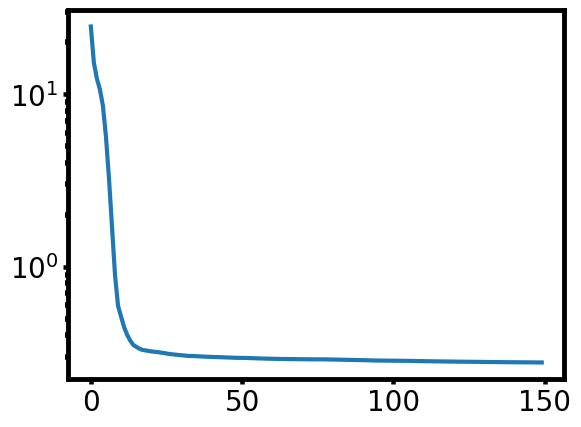

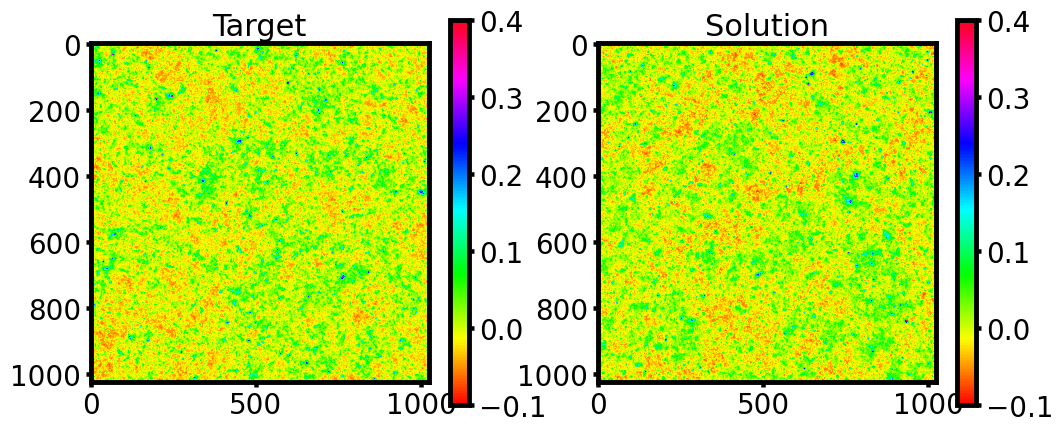

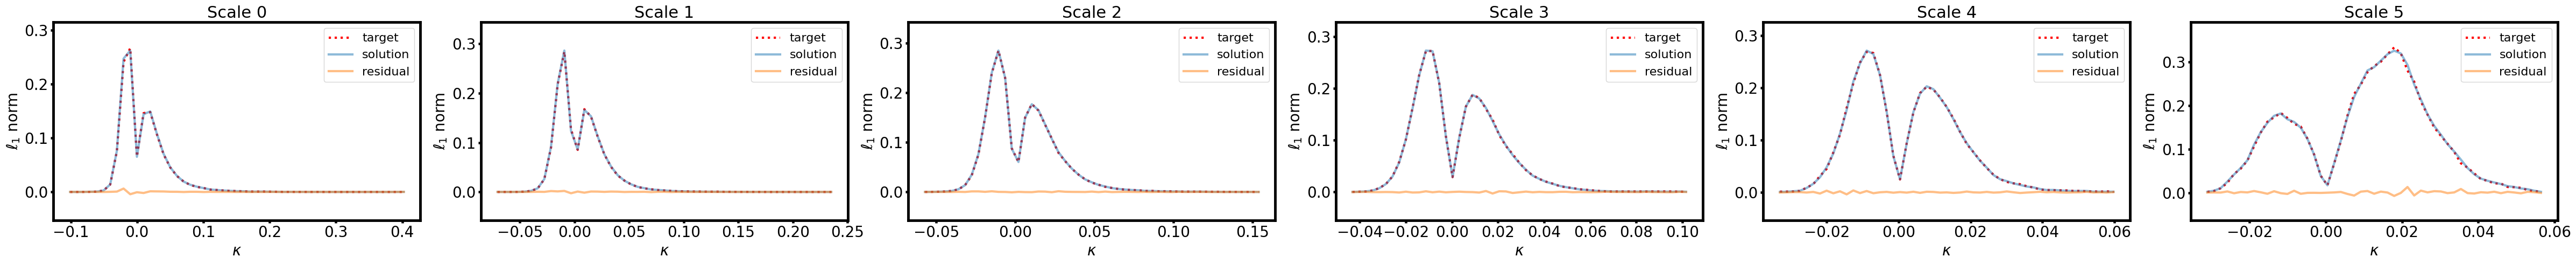

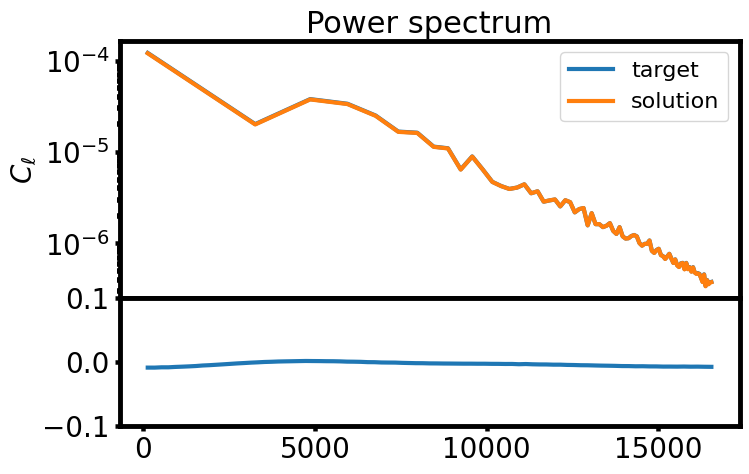

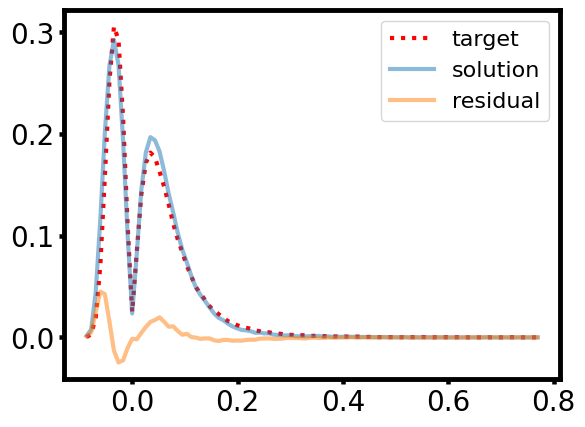

In [56]:
path = '/feynman/work/dap/lcs/vt272285/data/SLICS/2.007kappa_weight.dat_LOS400'
angle = 10
loader = SimulationDataLoader(user_defined_angle=angle) 

loaded_data, loaded_angle = loader.load_data(path)
data_downscaled = downscale_local_mean(loaded_data-np.mean(loaded_data), (4, 4))

N = 128*8
filter_type = 'tophat'
nscales = 5
print("The number of scales is: ", nscales)
nbins = [51]*(nscales+1)
target = data_downscaled[:N,:N]
pixelsize = loaded_angle.value * 60 / data_downscaled.shape[0]  # arcmin
print("the target pixelsize is: ", pixelsize)
print("the target size is: ", target.shape)

# adjuster = PowerSpectrumAdjuster(map_shape=target.shape, pixel_size=pixelsize)
# target_ells, target_cls = adjuster.compute_power_spectrum(target)

pkadjuster = PowerSpectrum(target, pixelsize)
_, target_ells, target_cls = pkadjuster.calculate_Cls(target)

decomposer = WaveletDecomposer()
density = True
target_values = process_image(target, filter_type, nscales, nbins, decomposer, density=density)

# seed = 10
# np.random.seed(seed)
gaussian = np.random.normal(0., np.std(target), target.shape)

# adjuster = PowerSpectrumAdjuster(map_shape=gaussian.shape, pixel_size=pixelsize)
pkadjuster = PowerSpectrum(gaussian, pixelsize)
solution = gaussian
total_error = []

print("The number of scales is: ", nscales)
for iter in range(150):
    solution_coefs = decomposer.decompose(solution,  num_scales=nscales, filter_type=filter_type, recalculate_params=True)
    error_per_scale = 0.
    for scale in range(nscales+1):
        print(f"\r Iteration: {iter} Scale: {scale}", end="", flush=True)
        
        # solution_coefs[scale], err = adjust_map_l1(solution_coefs[scale], mask=None, targetvalues=target_values[f'scale_{scale}'], density=density)
        solution_coefs[scale], err = adjust_pixel_values(solution_coefs[scale], mask=None, targetvalues=target_values[f'scale_{scale}'], density=density) 
        error_per_scale += err
        
    total_error.append(error_per_scale)
    solution_l1 = np.sum(solution_coefs, axis=0)
    
    if iter%1 ==0:
        # solution_cl = adjuster.adjust_map_cls(solution, target_values['cls'], target_values['ells'])
        solution_cl = pkadjuster.generate_field_with_target_cls(solution,  target_cls, target_ells)

        solution =  0.5 * (solution_cl + solution_l1)
    else:
        solution = solution_l1
      
    solution = np.clip(solution, np.min(target), np.max(target))
    
plt.figure()
plt.plot(np.array(total_error)*100)
plt.yscale('log')
plt.show()

plt.figure(figsize=(12,5))
vmin = -0.1
vmax = 0.4
cmap ='hsv'
plt.subplot(1,2,1)
plt.imshow(target, vmin=vmin, vmax=vmax, cmap=cmap)
plt.title('Target')
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(solution, vmin=vmin, vmax=vmax, cmap=cmap)
plt.title('Solution')
plt.colorbar()
plt.show()

solution_coefs = decomposer.decompose(solution,  num_scales=nscales, filter_type=filter_type, recalculate_params=True)

fig, axs = plt.subplots(1, nscales+1, figsize=(8*(nscales+1), 5))
for scale in range(nscales+1):
    edges_target = target_values[f'scale_{scale}']['binedges']
    centers_target = target_values[f'scale_{scale}']['bincenters']
    l1_target = target_values[f'scale_{scale}']['l1_norm']
    solution_edges, solution_centers, solution_hist, solution_l1norm = calculate_histogram_l1norm(solution_coefs[scale], mask=None, nbins=edges_target, density=density)
    
    axs[scale].plot(centers_target, l1_target, label='target', ls=":",c='r' )
    axs[scale].plot(solution_centers, solution_l1norm, label='solution', alpha=0.5)
    axs[scale].plot(centers_target,  solution_l1norm - l1_target , label='residual', alpha=0.5)
    axs[scale].legend()
    axs[scale].set_title(f'Scale {scale}')
    axs[scale].set_xlabel(r"$\kappa$")
    axs[scale].set_ylabel(r"$\ell_1$ norm")
    axs[scale].set_ylim(np.min(solution_l1norm)-(np.max(solution_l1norm)/5), np.max(solution_l1norm)+(np.max(solution_l1norm)/5))
    
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,5))
gs = GridSpec(2, 1, height_ratios=[2, 1], hspace=0)  # hspace=0 removes vertical gapplt.subplot(gs[0])
plt.subplot(gs[0])
plt.loglog(target_ells, target_cls, label='target')
# solutionells, solutioncls = adjuster.compute_power_spectrum(solution)
_, solutionells, solutioncls = pkadjuster.calculate_Cls(solution)
plt.loglog(solutionells, solutioncls, label='solution')
plt.legend()
plt.title('Power spectrum')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_\ell$')

plt.subplot(gs[1])
solution_cls_spline = CubicSpline(solutionells, solutioncls)
plt.plot(target_ells, (solution_cls_spline(target_ells) - target_cls)/target_cls, label='solution - target')
plt.ylim(-0.1, 0.1)
plt.show()

edges_target, center_target, hist_target, l1_target = calculate_histogram_l1norm(target, mask=None, nbins=100, density=density)
edges_solution, center_solution, hist_solution, l1_solution = calculate_histogram_l1norm(solution, mask=None, nbins=edges_target, density=density)

plt.figure()
plt.plot(center_target, l1_target, label='target', ls=":",c='r' )
plt.plot(center_solution, l1_solution, label='solution', alpha=0.5)
plt.plot(center_target,  l1_solution - l1_target , label='residual', alpha=0.5)
plt.legend()
plt.show()

1937 0.3097573567372225


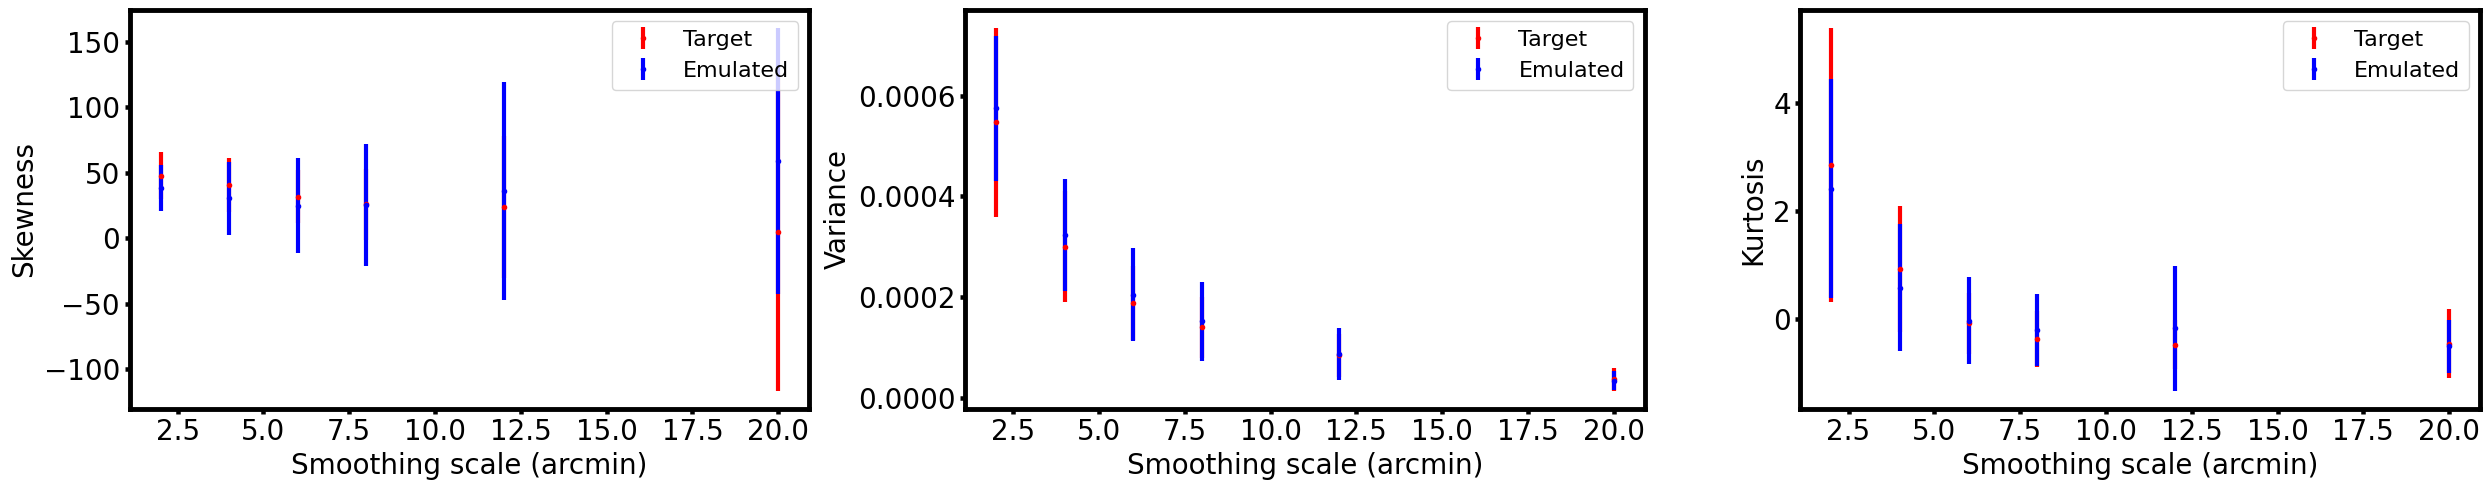

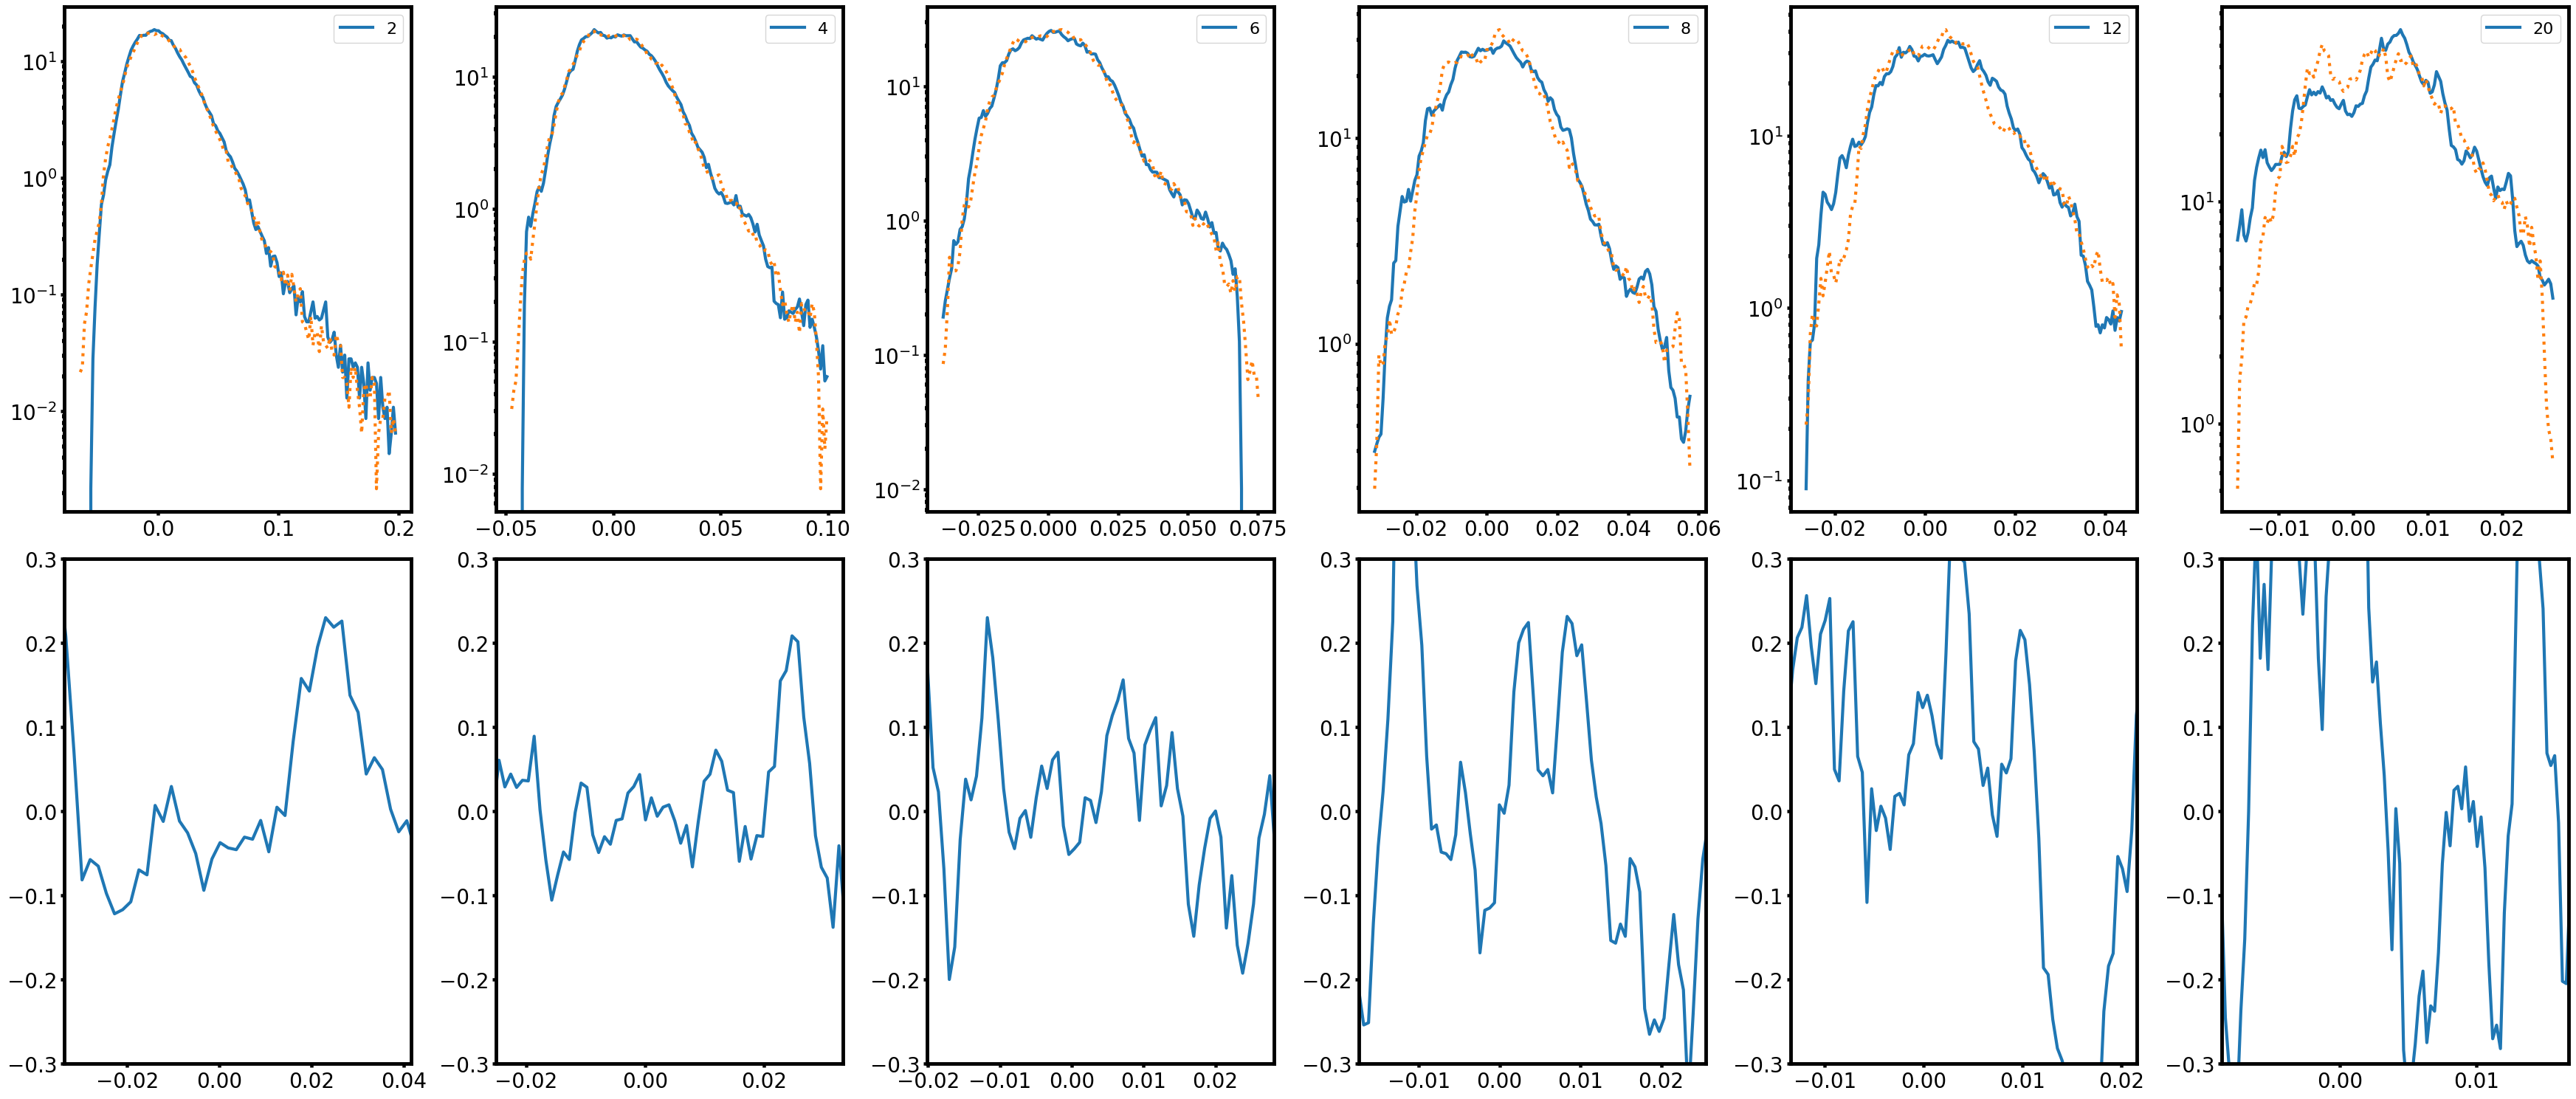

array([ 6, 12, 19, 25, 38, 64])

In [3]:


N_mesh = data_downscaled.shape[0]
target_image = target
final_map = solution
L = 505
pixsize=pixelsize #arcmin
print(N_mesh, pixsize)

theta1 = np.array([2, 4,  6,  8,  12, 20]) 
theta1_pixels = (theta1/pixsize).astype(int)

fig, axs = plt.subplots(1, 3, figsize=(25, 5))
# Flags to control labeling in the legend
first_label_target = True
first_label_emulated = True

for i, theta1s in enumerate(theta1_pixels):
    emulated_smoothed = decomposer.get_th_smooth_map(final_map, theta1s) 
    target_smoothed = decomposer.get_th_smooth_map(target_image, theta1s) 
    emu_patches = split_image_into_patches(emulated_smoothed, 4)
    tar_patches = split_image_into_patches(target_smoothed, 4)
    
    emu_mean = []
    emu_variance = []
    emu_skewness = []
    emu_kurtosis = []
    tar_mean = []
    tar_variance = []
    tar_skewness = []
    tar_kurtosis = []
    for no_patch in range(len(emu_patches)):
        emulated_mean, emulated_variance, emulated_skewness, emulated_kurtosis = get_moments_from_map(emu_patches[no_patch])
        target_mean, target_variance, target_skewness, target_kurtosis = get_moments_from_map(tar_patches[no_patch])
        emu_mean.append(emulated_mean)
        emu_variance.append(emulated_variance)
        emu_skewness.append(emulated_skewness)
        emu_kurtosis.append(emulated_kurtosis)
        tar_mean.append(target_mean)
        tar_variance.append(target_variance)
        tar_skewness.append(target_skewness)
        tar_kurtosis.append(target_kurtosis)
    
    
    axs[0].errorbar(theta1[i], np.average(tar_skewness), yerr=np.std(tar_skewness), c='r', label='Target' if first_label_target else "", fmt='o')
    axs[0].errorbar(theta1[i], np.average(emu_skewness), yerr=np.std(emu_skewness),fmt='o', c='b')
    axs[0].set_xlabel("Smoothing scale (arcmin)")
    axs[0].set_ylabel("Skewness")
    
    axs[1].errorbar(theta1[i], np.average(tar_variance),yerr=np.std(tar_variance),fmt='o', c='r', label='Target' if first_label_target else "")
    axs[1].errorbar(theta1[i], np.average(emu_variance),yerr=np.std(emu_variance),fmt='o', c='b')
    axs[1].set_xlabel("Smoothing scale (arcmin)")
    axs[1].set_ylabel("Variance")
    
    axs[2].errorbar(theta1[i], np.average(tar_kurtosis), c='r', yerr=np.std(tar_kurtosis), fmt='o',label='Target' if first_label_target else "")
    axs[2].errorbar(theta1[i], np.average(emu_kurtosis), yerr=np.std(emu_kurtosis), fmt='o', c='b')
    axs[2].set_xlabel("Smoothing scale (arcmin)")
    axs[2].set_ylabel("Kurtosis")
   
# Fetch unique handles and labels after plotting
handles_skewness, labels_skewness = axs[0].get_legend_handles_labels()
handles_variance, labels_variance = axs[1].get_legend_handles_labels()
handles_kurtosis, labels_variance = axs[2].get_legend_handles_labels()

# Create legends
axs[0].legend(['Target', 'Emulated'], loc='best')
axs[1].legend(['Target', 'Emulated'], loc='best')
axs[2].legend(['Target', 'Emulated'], loc='best')


plt.tight_layout()
plt.show()

# fig, axs = plt.subplots(2, len(theta1), figsize=(35, 15)) 

# for i, theta1s in enumerate(theta1_pixels):
#     emulated_smoothed = decomposer.get_th_smooth_map(final_map, theta1s) 
#     target_smoothed = decomposer.get_th_smooth_map(target_image, theta1s) 
    
#     edges_emulated, bin_centers_emulated, counts_emulated, l1norm_emulated = calculate_histogram_l1norm(emulated_smoothed, None, 150, density=True) #calculate_pdf(emulated_smoothed, 150)
#     edges_target, bin_centers_target, counts_target, l1norm_target = calculate_histogram_l1norm(target_smoothed, None, edges_emulated, density=True)
#     axs[0,i].plot(bin_centers_target, counts_target, label=theta1[i])
#     axs[0,i].plot(bin_centers_emulated, counts_emulated, ls=":")
#     axs[0,i].set_yscale('log')
#     axs[0,i].legend()
    
#     axs[1,i].plot(bin_centers_target, (counts_emulated/(counts_target + 1e-10)) - 1, label=theta1[i])
#     axs[1,i].set_ylim(-0.3,0.3)
#     axs[1,i].set_xlim(np.mean(emulated_smoothed)-1.5*np.std(emulated_smoothed), np.mean(emulated_smoothed)+1.5*np.std(emulated_smoothed))
    
# plt.tight_layout()
# plt.show() 
theta1_pixels

### Using the theory pred

In [2]:
def compute_binedges(bincenters):
    """
    Compute bin edges from bin centers.

    Parameters:
        bincenters (numpy.ndarray): Array of bin centers.

    Returns:
        numpy.ndarray: Array of bin edges.
    """
    # Calculate bin widths (differences between consecutive bin centers)
    bin_widths = np.diff(bincenters)

    # Initialize an array for edges
    edges = np.zeros(len(bincenters) + 1)
    edges[1:-1] = bincenters[:-1] + bin_widths / 2  # Midpoints between centers

    # Add the first and last edges
    edges[0] = bincenters[0] - 0.5 * bin_widths[0]
    edges[-1] = bincenters[-1] + 0.5 * bin_widths[-1]

    return edges

Processing LOS /feynman/work/dap/lcs/vt272285/data/SLICS/2.007kappa_weight.dat_LOS406: Data shape = (775, 775), Pixel size = 0.77 arcmin


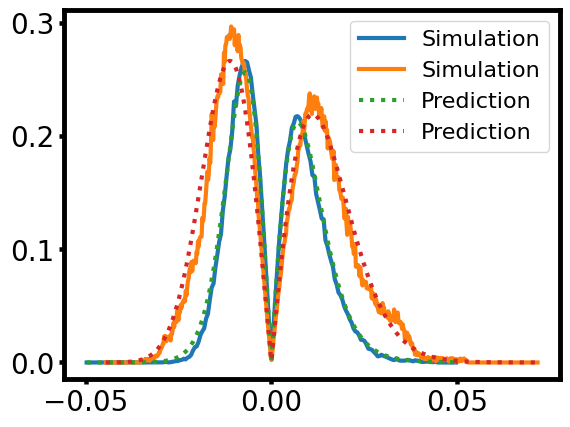

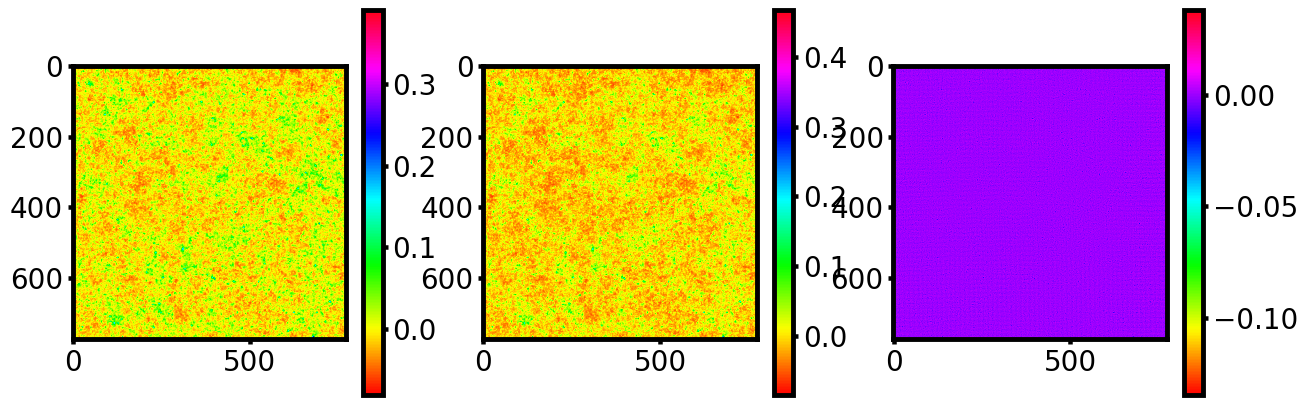

(200,)

In [85]:
# theoryw3 = np.load('/feynman/work/dap/lcs/vt272285/LDT_2cell_l1_norm/slics_data_for_emulator/theory_values_2_134_[3.0987734].npy') 



theoryw4 = np.load('/feynman/work/dap/lcs/vt272285/LDT_2cell_l1_norm/slics_data_for_emulator/theory_values_2_134_[6.1975468].npy')
theoryc5 = np.load('/feynman/work/dap/lcs/vt272285/LDT_2cell_l1_norm/slics_data_for_emulator/[12.39509361].npy')


kappaw4 = -theoryw4.T[0]
sortindices = np.argsort(kappaw4)
kappaw4 = kappaw4[sortindices]
edgesw4 = compute_binedges(kappaw4)
predictionl1w4 = theoryw4.T[2][sortindices]
predictionhistw4 = theoryw4.T[1][sortindices]

kappac5 = theoryc5.T[0]
edgesc5 = compute_binedges(kappac5)
predictionl1c5 = theoryc5.T[2]
predictionhistc5 = theoryc5.T[1]


base_path = '/feynman/work/dap/lcs/vt272285/data/SLICS/2.007kappa_weight.dat_LOS406'

angle = 10
loader = SimulationDataLoader(user_defined_angle=angle) 
loaded_data, loaded_angle = loader.load_data(base_path)
data_downscaled = downscale_local_mean(loaded_data - np.mean(loaded_data), (10, 10))

pixelsize = loaded_angle.value * 60 / data_downscaled.shape[0]  # arcmin

print(f"Processing LOS {base_path}: Data shape = {data_downscaled.shape}, Pixel size = {pixelsize:.2f} arcmin")
    
nbins = [101, 101, 101, 101, 101, 101, 101]
nscales = 4
filter_type = 'tophat'

target = data_downscaled[:-1,:-1]
decomposer = WaveletDecomposer()
target_coeffs = decomposer.decompose(target, num_scales=nscales, filter_type=filter_type, recalculate_params=True)

edges_w3, centersw3, hist_w3, l1norm_w3 = calculate_histogram_l1norm(target_coeffs[3], None, edgesw4, density=True)
edges_c5, centersc5, hist_c5, l1norm_c5 = calculate_histogram_l1norm(target_coeffs[4], None, edgesc5, density=True)

plt.plot(centersw3, l1norm_w3, label='Simulation')
plt.plot(centersc5, l1norm_c5, label='Simulation')
plt.plot(kappaw4, predictionl1w4, label='Prediction', ls=":")
plt.plot(kappac5, predictionl1c5, label='Prediction', ls=":")
plt.legend()
plt.show()

recon_tar = np.sum(target_coeffs[-2:], axis=0)
recon_tar_deconv = wiener_deconvolution_flat(decomposer, recon_tar, 8, reg_param=1e-7, k_cutoff=0.5)

plt.figure(figsize = (15,5))
plt.subplot(1,3,1)
plt.imshow(recon_tar_deconv, cmap='hsv')
plt.colorbar()
plt.subplot(1,3,2)
plt.imshow(target, cmap='hsv')
plt.colorbar()
plt.subplot(1,3,3)
plt.imshow(recon_tar_deconv - target, cmap='hsv')
plt.colorbar()
plt.show()

edgesw4.shape

The number of scales is:  4
 Iteration: 49  Scale: 4
 the error at the end is:  0.8397673239044846


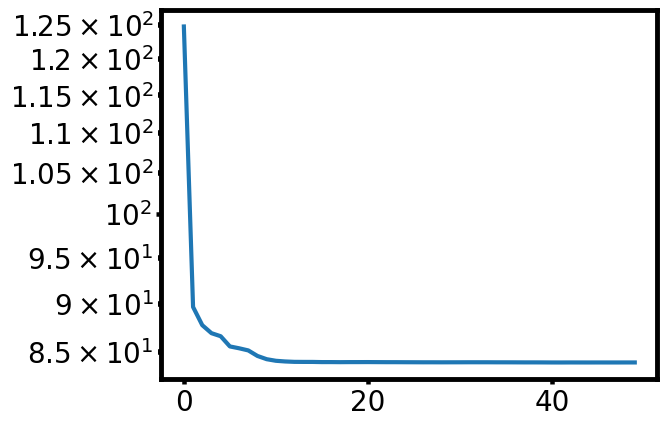

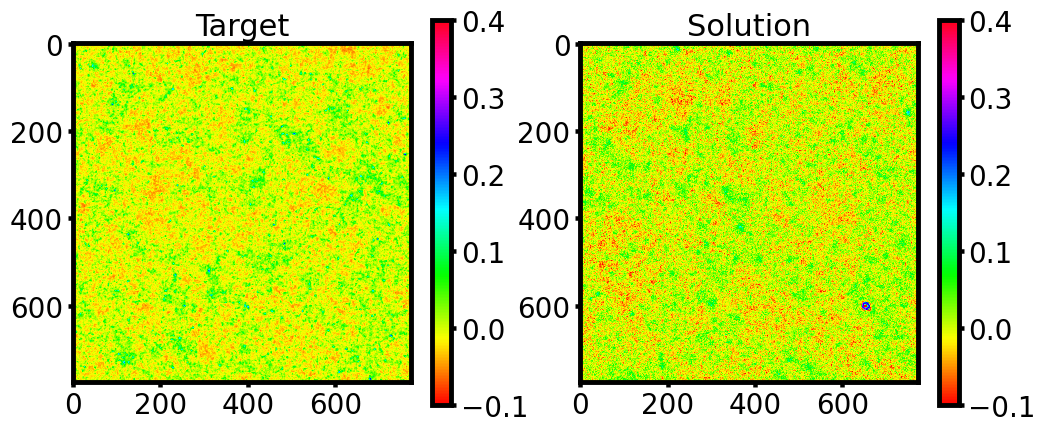

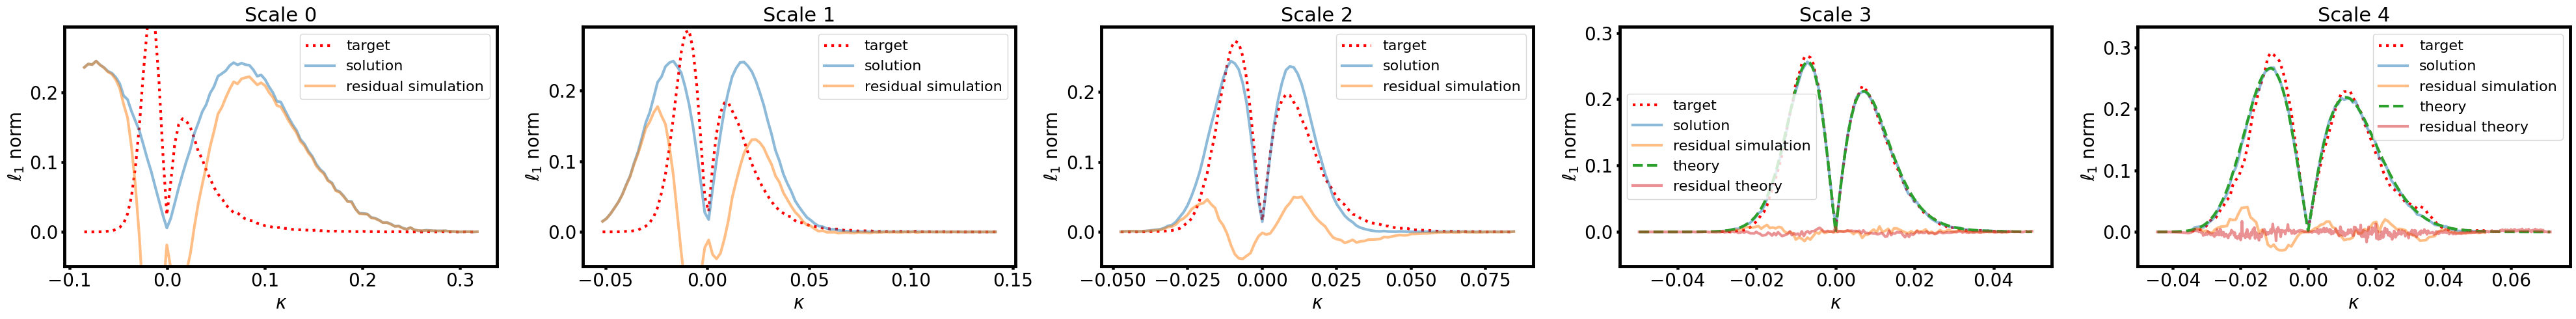

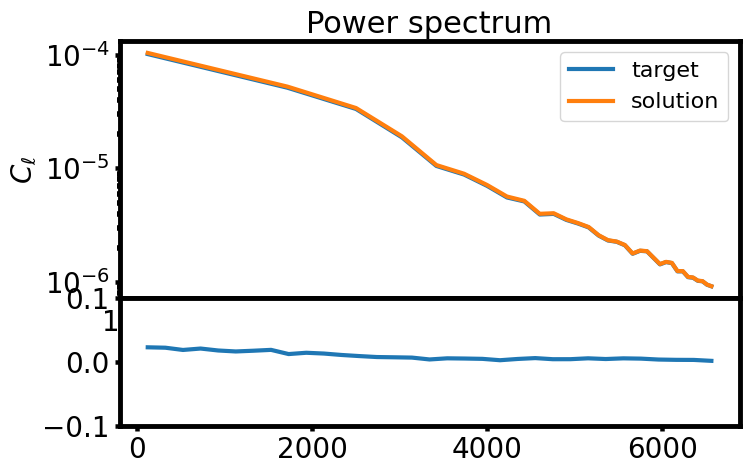

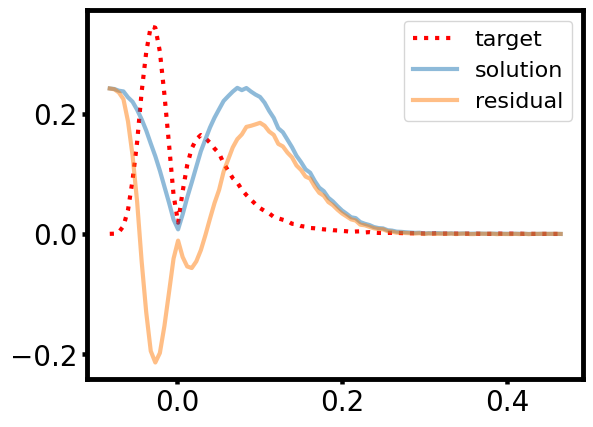

In [93]:
pkadjuster = PowerSpectrum(target, pixelsize)
_, target_ells, target_cls = pkadjuster.calculate_Cls(target)
_, target_ells_w0, target_cls_w0 = pkadjuster.calculate_Cls(target_coeffs[0])
_, target_ells_w1, target_cls_w1 = pkadjuster.calculate_Cls(target_coeffs[1])
_, target_ells_w2, target_cls_w2 = pkadjuster.calculate_Cls(target_coeffs[2])

target_values = {}
target_values['scale_3'] = {'binedges': edgesw4, 'bincenters': kappaw4, 'histogram': predictionhistw4, 'l1_norm': predictionl1w4}
target_values['scale_4'] = {'binedges': edgesc5, 'bincenters': kappac5, 'histogram': predictionhistc5, 'l1_norm': predictionl1c5}

# target_values = {} #edges_w3, centersw3, hist_w3, l1norm_w3
# target_values['scale_3'] = {'binedges': edges_w3, 'bincenters': centersw3, 'histogram': hist_w3, 'l1_norm': l1norm_w3}
# target_values['scale_4'] = {'binedges': edges_c5, 'bincenters': centersc5, 'histogram': hist_c5, 'l1_norm': l1norm_c5}

seed = 10
np.random.seed(seed)
gaussian = np.random.normal(0., np.std(target), target.shape)

pkadjuster = PowerSpectrum(gaussian, pixelsize)

solution = gaussian
total_error = []

density= True
print("The number of scales is: ", nscales)
for iter in range(50):
    # solution = pkadjuster.generate_field_with_target_cls(solution,  target_cls, target_ells)
    solution_coefs = decomposer.decompose(solution,  num_scales=nscales, filter_type=filter_type, recalculate_params=True)
    error_per_scale = 0.
    
    for scale in range(nscales+1):
        print(f"\r Iteration: {iter}  Scale: {scale}", end="", flush=True)
        if scale<3:
            target_cls_w = globals()[f"target_cls_w{scale}"]
            target_ells_w = globals()[f"target_ells_w{scale}"]
            solution_coefs[scale] = pkadjuster.generate_field_with_target_cls(solution_coefs[scale], target_cls_w, target_ells_w)        
        else:
            solution_coefs[scale], err = adjust_pixel_values(solution_coefs[scale], mask=None, targetvalues=target_values[f'scale_{scale}'], density=density) 
            error_per_scale += err
            # solution_coefs[scale] = np.clip(solution_coefs[scale], np.min(target_coeffs[scale]), np.max(target_coeffs[scale]))
    total_error.append(error_per_scale)
    
    if iter>5000:
        solution_l1 = np.sum(solution_coefs[-2:], axis=0)
        solution_l1 = wiener_deconvolution_flat(decomposer, solution_l1, 8, reg_param=5e-4, k_cutoff=0.6)
    else:
        solution_l1 = np.sum(solution_coefs, axis=0)

    if iter%1 ==0:
        solution_cl = pkadjuster.generate_field_with_target_cls(solution,  target_cls, target_ells)
        solution =  0.5 * (solution_cl + solution_l1)
    else:
        solution = solution_l1
      
    # solution = np.clip(solution, np.min(target), np.max(target))
    
print("\n the error at the end is: ", total_error[-1])
plt.figure()
plt.plot(np.array(total_error)*100)
plt.yscale('log')
plt.show()

plt.figure(figsize=(12,5))
vmin = -0.1
vmax = 0.4
cmap ='hsv'
plt.subplot(1,2,1)
plt.imshow(target, vmin=vmin, vmax=vmax, cmap=cmap)
plt.title('Target')
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(solution, vmin=vmin, vmax=vmax, cmap=cmap)
plt.title('Solution')
plt.colorbar()
plt.show()

target_values_ = process_image(target, filter_type, nscales, nbins, decomposer, density=density)

solution_coefs = decomposer.decompose(solution,  num_scales=nscales, filter_type=filter_type, recalculate_params=True)

fig, axs = plt.subplots(1, nscales+1, figsize=(8*(nscales+1), 5))
for scale in range(nscales+1):
    edges_target = target_values_[f'scale_{scale}']['binedges']
    centers_target = target_values_[f'scale_{scale}']['bincenters']
    l1_target = target_values_[f'scale_{scale}']['l1_norm']
    solution_edges, solution_centers, solution_hist, solution_l1norm = calculate_histogram_l1norm(solution_coefs[scale], mask=None, nbins=edges_target, density=density)
    
    axs[scale].plot(centers_target, l1_target, label='target', ls=":",c='r' )
    axs[scale].plot(solution_centers, solution_l1norm, label='solution', alpha=0.5)
    axs[scale].plot(centers_target,  solution_l1norm - l1_target , label='residual simulation', alpha=0.5)
    
    if scale>=3:
        edges_target = target_values[f'scale_{scale}']['binedges']
        solution_edges, solution_centers, solution_hist, solution_l1norm = calculate_histogram_l1norm(solution_coefs[scale], mask=None, nbins=edges_target, density=density)
        axs[scale].plot(target_values[f'scale_{scale}']['bincenters'], target_values[f'scale_{scale}']['l1_norm'], label='theory', ls="--")
        axs[scale].plot(solution_centers,  solution_l1norm - target_values[f'scale_{scale}']['l1_norm'] , label='residual theory', alpha=0.5) 
    axs[scale].legend()
    axs[scale].set_title(f'Scale {scale}')
    axs[scale].set_xlabel(r"$\kappa$")
    axs[scale].set_ylabel(r"$\ell_1$ norm")
    axs[scale].set_ylim(np.min(solution_l1norm)-(np.max(solution_l1norm)/5), np.max(solution_l1norm)+(np.max(solution_l1norm)/5))
    
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,5))
gs = GridSpec(2, 1, height_ratios=[2, 1], hspace=0)  # hspace=0 removes vertical gapplt.subplot(gs[0])
plt.subplot(gs[0])
plt.loglog(target_ells, target_cls, label='target')
# solutionells, solutioncls = adjuster.compute_power_spectrum(solution)
_, solutionells, solutioncls = pkadjuster.calculate_Cls(solution)
plt.loglog(solutionells, solutioncls, label='solution')
plt.legend()
plt.title('Power spectrum')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_\ell$')

plt.subplot(gs[1])
solution_cls_spline = CubicSpline(solutionells, solutioncls)
plt.plot(target_ells, (solution_cls_spline(target_ells) - target_cls)/target_cls, label='solution - target')
plt.ylim(-0.1, 0.1)
plt.show()

edges_target, center_target, hist_target, l1_target = calculate_histogram_l1norm(target, mask=None, nbins=100, density=density)
edges_solution, center_solution, hist_solution, l1_solution = calculate_histogram_l1norm(solution, mask=None, nbins=edges_target, density=density)

plt.figure()
plt.plot(center_target, l1_target, label='target', ls=":",c='r' )
plt.plot(center_solution, l1_solution, label='solution', alpha=0.5)
plt.plot(center_target,  l1_solution - l1_target , label='residual', alpha=0.5)
plt.legend()
plt.show()

775 0.7741935483870968


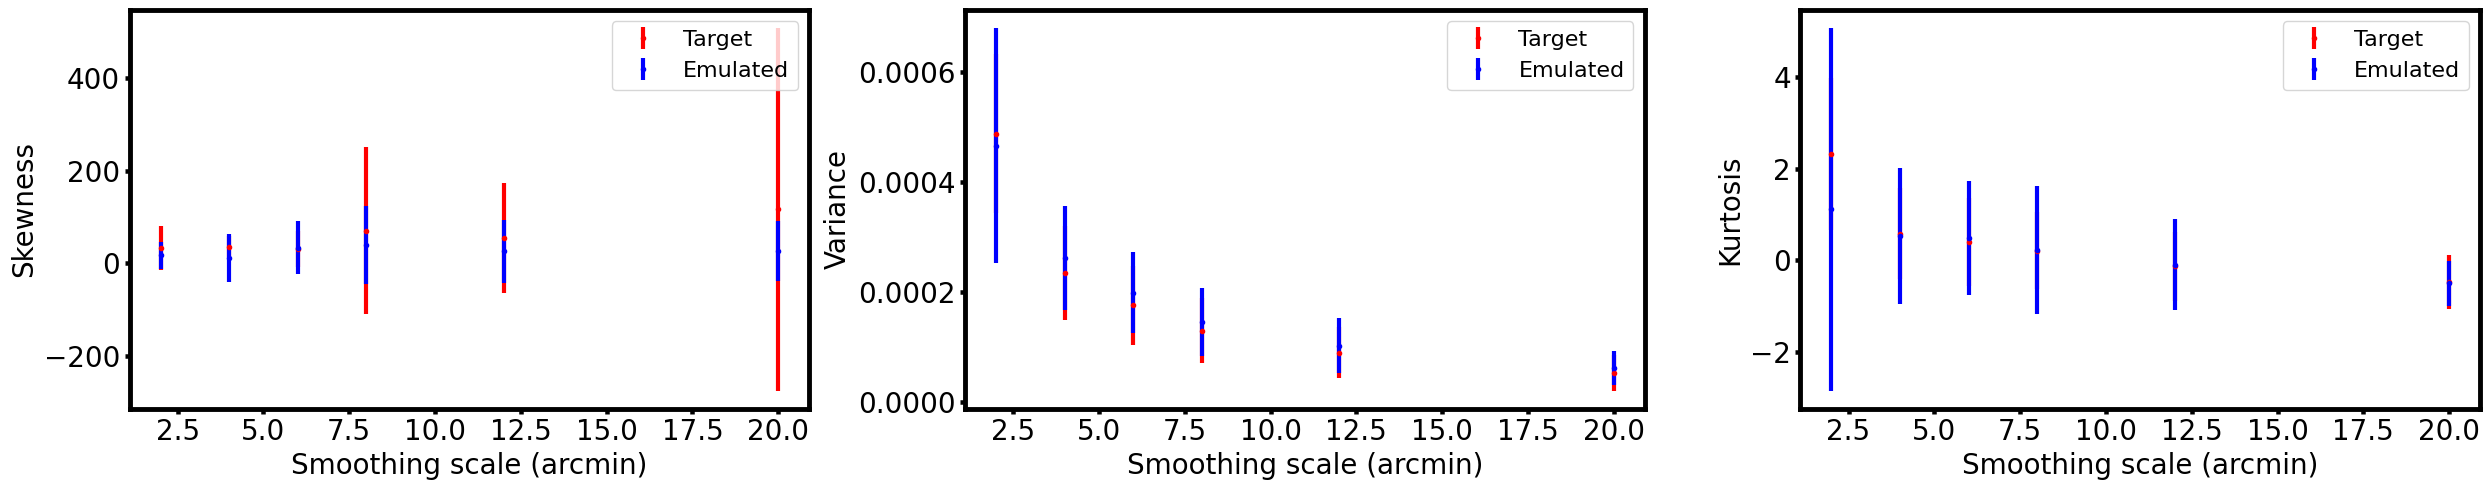

array([ 2,  5,  7, 10, 15, 25])

In [84]:
N_mesh = data_downscaled.shape[0]
target_image = target
final_map = solution
L = 505
pixsize=pixelsize #arcmin
print(N_mesh, pixsize)

theta1 = np.array([2, 4,  6,  8,  12, 20]) 
theta1_pixels = (theta1/pixsize).astype(int)

fig, axs = plt.subplots(1, 3, figsize=(25, 5))
# Flags to control labeling in the legend
first_label_target = True
first_label_emulated = True

for i, theta1s in enumerate(theta1_pixels):
    emulated_smoothed = decomposer.get_th_smooth_map(final_map, theta1s) 
    target_smoothed = decomposer.get_th_smooth_map(target_image, theta1s) 
    emu_patches = split_image_into_patches(emulated_smoothed, 4)
    tar_patches = split_image_into_patches(target_smoothed, 4)
    
    emu_mean = []
    emu_variance = []
    emu_skewness = []
    emu_kurtosis = []
    tar_mean = []
    tar_variance = []
    tar_skewness = []
    tar_kurtosis = []
    for no_patch in range(len(emu_patches)):
        emulated_mean, emulated_variance, emulated_skewness, emulated_kurtosis = get_moments_from_map(emu_patches[no_patch])
        target_mean, target_variance, target_skewness, target_kurtosis = get_moments_from_map(tar_patches[no_patch])
        emu_mean.append(emulated_mean)
        emu_variance.append(emulated_variance)
        emu_skewness.append(emulated_skewness)
        emu_kurtosis.append(emulated_kurtosis)
        tar_mean.append(target_mean)
        tar_variance.append(target_variance)
        tar_skewness.append(target_skewness)
        tar_kurtosis.append(target_kurtosis)
    
    
    axs[0].errorbar(theta1[i], np.average(tar_skewness), yerr=np.std(tar_skewness), c='r', label='Target' if first_label_target else "", fmt='o')
    axs[0].errorbar(theta1[i], np.average(emu_skewness), yerr=np.std(emu_skewness),fmt='o', c='b')
    axs[0].set_xlabel("Smoothing scale (arcmin)")
    axs[0].set_ylabel("Skewness")
    
    axs[1].errorbar(theta1[i], np.average(tar_variance),yerr=np.std(tar_variance),fmt='o', c='r', label='Target' if first_label_target else "")
    axs[1].errorbar(theta1[i], np.average(emu_variance),yerr=np.std(emu_variance),fmt='o', c='b')
    axs[1].set_xlabel("Smoothing scale (arcmin)")
    axs[1].set_ylabel("Variance")
    
    axs[2].errorbar(theta1[i], np.average(tar_kurtosis), c='r', yerr=np.std(tar_kurtosis), fmt='o',label='Target' if first_label_target else "")
    axs[2].errorbar(theta1[i], np.average(emu_kurtosis), yerr=np.std(emu_kurtosis), fmt='o', c='b')
    axs[2].set_xlabel("Smoothing scale (arcmin)")
    axs[2].set_ylabel("Kurtosis")
   
# Fetch unique handles and labels after plotting
handles_skewness, labels_skewness = axs[0].get_legend_handles_labels()
handles_variance, labels_variance = axs[1].get_legend_handles_labels()
handles_kurtosis, labels_variance = axs[2].get_legend_handles_labels()

# Create legends
axs[0].legend(['Target', 'Emulated'], loc='best')
axs[1].legend(['Target', 'Emulated'], loc='best')
axs[2].legend(['Target', 'Emulated'], loc='best')


plt.tight_layout()
plt.show()

# fig, axs = plt.subplots(2, len(theta1), figsize=(35, 15)) 

# for i, theta1s in enumerate(theta1_pixels):
#     emulated_smoothed = decomposer.get_th_smooth_map(final_map, theta1s) 
#     target_smoothed = decomposer.get_th_smooth_map(target_image, theta1s) 
    
#     edges_emulated, bin_centers_emulated, counts_emulated, l1norm_emulated = calculate_histogram_l1norm(emulated_smoothed, None, 150, density=True) #calculate_pdf(emulated_smoothed, 150)
#     edges_target, bin_centers_target, counts_target, l1norm_target = calculate_histogram_l1norm(target_smoothed, None, edges_emulated, density=True)
#     axs[0,i].plot(bin_centers_target, counts_target, label=theta1[i])
#     axs[0,i].plot(bin_centers_emulated, counts_emulated, ls=":")
#     axs[0,i].set_yscale('log')
#     axs[0,i].legend()
    
#     axs[1,i].plot(bin_centers_target, (counts_emulated/(counts_target + 1e-10)) - 1, label=theta1[i])
#     axs[1,i].set_ylim(-0.3,0.3)
#     axs[1,i].set_xlim(np.mean(emulated_smoothed)-1.5*np.std(emulated_smoothed), np.mean(emulated_smoothed)+1.5*np.std(emulated_smoothed))
    
# plt.tight_layout()
# plt.show() 
theta1_pixels